In [ ]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import numpy as np
#from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV

import nltk
nltk.download('stopwords')
nltk.download('punkt')

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow import convert_to_tensor
from keras.layers import Embedding,LSTM,GRU,Dense,Dropout,Conv1D,MaxPool1D,BatchNormalization


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
! pip install scikeras
from scikeras.wrappers import KerasClassifier

here I download the file to do embeddings

In [ ]:
import os

# Check if the file already exists
if not os.path.exists("glove.6B.zip"):
    # If the file doesn't exist, download it
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    # Unzip the downloaded file
    !unzip glove*.zip
else:
    print("File already downloaded.")


--2023-07-17 11:46:04--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-07-17 11:46:04--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-07-17 11:46:04--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

# Input


In this first part we make an analysis of the dataset to see which fields we'll use.
In principle I wanted to use them all, except for the 'userID' so I did all the preprocessing part for each column but at the end I didn't use them since all the one-hot-encoded categories were too heavy combined with the reviews.

We use a gitHub link to read our dataset

In [ ]:
import pandas as pd

df = pd.read_csv("https://github.com/MikiTwenty/Python/blob/main/Colab/DL-Exam/parkReviews.csv?raw=true", encoding='latin-1')
pd.set_option('display.max_columns', None)

print(df.head())

   Review_ID  Rating Year_Month     Reviewer_Location  \
0  670772142       4     2019-4             Australia   
1  670682799       4     2019-5           Philippines   
2  670623270       4     2019-4  United Arab Emirates   
3  670607911       4     2019-4             Australia   
4  670607296       4     2019-4        United Kingdom   

                                         Review_Text               Branch  
0  If you've ever been to Disneyland anywhere you...  Disneyland_HongKong  
1  Its been a while since d last time we visit HK...  Disneyland_HongKong  
2  Thanks God it wasn   t too hot or too humid wh...  Disneyland_HongKong  
3  HK Disneyland is a great compact park. Unfortu...  Disneyland_HongKong  
4  the location is not in the city, took around 1...  Disneyland_HongKong  


We check if there are missing values. From a first analysis it seems that there are not, but when printinf 'df' we can see that there are some values labeled as 'missing' that need to be handled in a correct way.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [ ]:
df

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong
...,...,...,...,...,...,...
42651,1765031,5,missing,United Kingdom,i went to disneyland paris in july 03 and thou...,Disneyland_Paris
42652,1659553,5,missing,Canada,2 adults and 1 child of 11 visited Disneyland ...,Disneyland_Paris
42653,1645894,5,missing,South Africa,My eleven year old daughter and myself went to...,Disneyland_Paris
42654,1618637,4,missing,United States,"This hotel, part of the Disneyland Paris compl...",Disneyland_Paris


In [ ]:
df = df.drop('Review_ID', axis=1)

we deal with missing values

In [ ]:
df.replace('missing', np.nan, inplace=True)

In [ ]:
missing_values = df.isnull()

count_missingv = missing_values.sum() #it counts how many missing values there are per column
kind = df.dtypes  #it tells what kind of vaues they are

column_info = pd.concat([kind, count_missingv], axis=1, keys=['Data Type', 'Number of Missing Values'])

print(column_info[column_info['Number of Missing Values'] > 0])

           Data Type  Number of Missing Values
Year_Month    object                      2613


we first separate year and month so that we'll get two integer columns instead of an object one

In [ ]:
df['Year_Month'] = pd.to_datetime(df['Year_Month'])
df['Year'] = df['Year_Month'].dt.year
df['Month'] = df['Year_Month'].dt.month

we calculate the mean of the values we have and we replace all missing values with it

In [ ]:
imputer = SimpleImputer(strategy='most_frequent')

df['Year'] = imputer.fit_transform(df[['Year']])
df['Month'] = imputer.fit_transform(df[['Month']])

the next step is to select the column target, since our goal is to predict the rating, we drop such column and we create a dictionary where we map each number of stars to a value.
I'll talk more about it in the 'Output' part

In [ ]:
target = 'Rating'

y = df[target]

df.drop(columns=[target], inplace=True)

df

,Year_Month,Reviewer_Location,Review_Text,Branch,Year,Month
0,2019-04-01,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019.0,4.0
1,2019-05-01,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019.0,5.0
2,2019-04-01,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019.0,4.0
3,2019-04-01,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019.0,4.0
4,2019-04-01,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019.0,4.0
...,...,...,...,...,...,...
42651,NaT,United Kingdom,i went to disneyland paris in july 03 and thou...,Disneyland_Paris,2015.0,8.0
42652,NaT,Canada,2 adults and 1 child of 11 visited Disneyland ...,Disneyland_Paris,2015.0,8.0
42653,NaT,South Africa,My eleven year old daughter and myself went to...,Disneyland_Paris,2015.0,8.0
42654,NaT,United States,"This hotel, part of the Disneyland Paris compl...",Disneyland_Paris,2015.0,8.0


one-hot encoding:

In [ ]:
# we perform one-hot encoding for our columns, except the 'Review_Text' one,  since they're all non-integer
month = pd.get_dummies(df['Month'], prefix='Month')
year = pd.get_dummies(df['Year'], prefix='Year')
branch = pd.get_dummies(df['Branch'], prefix='Branch')
origin = pd.get_dummies(df['Reviewer_Location'], prefix='Origin')

In [ ]:
# Concatenate the one-hot encoded columns with the original DataFrame
df_encoded = pd.concat([df, month, year, branch, origin], axis=1)

In [ ]:
df_processed = df_encoded.drop(['Year_Month','Reviewer_Location','Branch', 'Year', 'Month'], axis=1)

In [ ]:
df_processed

,Review_Text,Month_1.0,Month_2.0,Month_3.0,Month_4.0,Month_5.0,Month_6.0,Month_7.0,Month_8.0,Month_9.0,Month_10.0,Month_11.0,Month_12.0,Year_2010.0,Year_2011.0,Year_2012.0,Year_2013.0,Year_2014.0,Year_2015.0,Year_2016.0,Year_2017.0,Year_2018.0,Year_2019.0,Branch_Disneyland_California,Branch_Disneyland_HongKong,Branch_Disneyland_Paris,Origin_Afghanistan,Origin_Albania,Origin_Algeria,Origin_Andorra,Origin_Antigua and Barbuda,Origin_Argentina,Origin_Armenia,Origin_Aruba,Origin_Australia,Origin_Austria,Origin_Azerbaijan,Origin_Bahrain,Origin_Bangladesh,Origin_Barbados,Origin_Belgium,Origin_Bolivia,Origin_Bosnia and Herzegovina,Origin_Botswana,Origin_Brazil,Origin_Brunei,Origin_Bulgaria,Origin_Cambodia,Origin_Canada,Origin_Caribbean Netherlands,Origin_Cayman Islands,Origin_Chile,Origin_China,Origin_Colombia,Origin_Cook Islands,Origin_Costa Rica,Origin_Croatia,Origin_Cuba,Origin_Curaçao,Origin_Cyprus,Origin_Czechia,Origin_Côte d'Ivoire,Origin_Democratic Republic of the Congo,Origin_Denmark,Origin_Dominican Republic,Origin_Ecuador,Origin_Egypt,Origin_El Salvador,Origin_Estonia,Origin_Ethiopia,Origin_Falkland Islands (Islas Malvinas),Origin_Fiji,Origin_Finland,Origin_France,Origin_French Polynesia,Origin_Georgia,Origin_Germany,Origin_Ghana,Origin_Gibraltar,Origin_Greece,Origin_Grenada,Origin_Guam,Origin_Guatemala,Origin_Guernsey,Origin_Haiti,Origin_Honduras,Origin_Hong Kong,Origin_Hungary,Origin_Iceland,Origin_India,Origin_Indonesia,Origin_Iran,Origin_Iraq,Origin_Ireland,Origin_Isle of Man,Origin_Israel,Origin_Italy,Origin_Jamaica,Origin_Japan,Origin_Jersey,Origin_Jordan,Origin_Kazakhstan,Origin_Kenya,Origin_Kuwait,Origin_Laos,Origin_Latvia,Origin_Lebanon,Origin_Libya,Origin_Lithuania,Origin_Luxembourg,Origin_Macau,Origin_Madagascar,Origin_Malawi,Origin_Malaysia,Origin_Maldives,Origin_Mali,Origin_Malta,Origin_Mauritius,Origin_Mexico,Origin_Moldova,Origin_Monaco,Origin_Mongolia,Origin_Montenegro,Origin_Morocco,Origin_Mozambique,Origin_Myanmar (Burma),Origin_Namibia,Origin_Nepal,Origin_Netherlands,Origin_New Zealand,Origin_Nicaragua,Origin_Nigeria,Origin_North Macedonia,Origin_Northern Mariana Islands,Origin_Norway,Origin_Oman,Origin_Pakistan,Origin_Panama,Origin_Papua New Guinea,Origin_Peru,Origin_Philippines,Origin_Poland,Origin_Portugal,Origin_Puerto Rico,Origin_Qatar,Origin_Romania,Origin_Russia,Origin_Rwanda,Origin_Saudi Arabia,Origin_Senegal,Origin_Serbia,Origin_Seychelles,Origin_Singapore,Origin_Slovakia,Origin_Slovenia,Origin_Solomon Islands,Origin_South Africa,Origin_South Korea,Origin_South Sudan,Origin_Spain,Origin_Sri Lanka,Origin_Sudan,Origin_Suriname,Origin_Sweden,Origin_Switzerland,Origin_Taiwan,Origin_Tanzania,Origin_Thailand,Origin_The Bahamas,Origin_Timor-Leste,Origin_Trinidad and Tobago,Origin_Tunisia,Origin_Turkey,Origin_Turks and Caicos Islands,Origin_U.S. Virgin Islands,Origin_Uganda,Origin_Ukraine,Origin_United Arab Emirates,Origin_United Kingdom,Origin_United States,Origin_Uruguay,Origin_Uzbekistan,Origin_Vanuatu,Origin_Venezuela,Origin_Vietnam,Origin_Zambia,Origin_Zimbabwe,Origin_Åland Islands
0,If you've ever been to Disneyland anywhere you...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Its been a while since d last time we visit HK...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Thanks God it wasn t too hot or too humid wh...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,

we start dealing with the text column, as a first step we to text cleaning


In [ ]:
df_processed['sequence_length'] = df_processed['Review_Text'].apply(lambda x: len(str(x).split()))

# Find the maximum, minimum, and mean lengths
max_length = df_processed['sequence_length'].max()
min_length = df_processed['sequence_length'].min()
mean_length = df_processed['sequence_length'].mean()

# Print the maximum, minimum, and mean lengths
print(f"Maximum sequence length: {max_length}")
print(f"Minimum sequence length: {min_length}")
print(f"Mean sequence length: {mean_length}")

Maximum sequence length: 3963
Minimum sequence length: 3
Mean sequence length: 129.70381657914479


In [ ]:
#extra whitespaces removal
def remove_whitespace(text):
    return  " ".join(text.split())

#lower case
df_processed['Review_Text']= df_processed['Review_Text'].str.lower()

#punctuation removal
df_processed['Review_Text'] = df_processed['Review_Text'].str.replace(r'[^\w\s]+', '', regex=True)
df_processed['Review_Text'] = df_processed['Review_Text'].str.replace('[.,]', '')

# whitespace removal
df_processed['Review_Text'] = df_processed['Review_Text'].apply(remove_whitespace)

#we print to chek
df_processed['Review_Text']

<ipython-input-19-60dd2e8951a1>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df_processed['Review_Text'] = df_processed['Review_Text'].str.replace('[.,]', '')


0        if youve ever been to disneyland anywhere youl...
1        its been a while since d last time we visit hk...
2        thanks god it wasn t too hot or too humid when...
3        hk disneyland is a great compact park unfortun...
4        the location is not in the city took around 1 ...
                               ...                        
42651    i went to disneyland paris in july 03 and thou...
42652    2 adults and 1 child of 11 visited disneyland ...
42653    my eleven year old daughter and myself went to...
42654    this hotel part of the disneyland paris comple...
42655    i went to the disneyparis resort in 1996 with ...
Name: Review_Text, Length: 42656, dtype: object

In [ ]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
# here we remove all the stopwords
df_processed['Review_Text'] = df_processed['Review_Text'].apply(lambda text: ' '.join([word for word in text.split() if word.lower() not in stopwords]))

Tokenization and lemmatization


In [ ]:
tokenized_corpus = [nltk.word_tokenize(text) for text in df_processed['Review_Text']]

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

# Lemmatize the tokenized text
corpus = [[lemmatizer.lemmatize(word) for word in text] for text in tokenized_corpus]


print("corpus :", corpus[:3], "lenght:", len(corpus))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


corpus : [['youve', 'ever', 'disneyland', 'anywhere', 'youll', 'find', 'disneyland', 'hong', 'kong', 'similar', 'layout', 'walk', 'main', 'street', 'familiar', 'feel', 'one', 'ride', 'small', 'world', 'absolutely', 'fabulous', 'worth', 'day', 'visited', 'fairly', 'hot', 'relatively', 'busy', 'queue', 'moved', 'fairly', 'well'], ['since', 'last', 'time', 'visit', 'hk', 'disneyland', 'yet', 'time', 'stay', 'tomorrowland', 'aka', 'marvel', 'landnow', 'iron', 'man', 'experience', 'n', 'newly', 'open', 'ant', 'man', 'n', 'waspironman', 'great', 'feature', 'n', 'exciting', 'especially', 'whole', 'scenery', 'hk', 'hk', 'central', 'area', 'kowloonantman', 'changed', 'previous', 'buzz', 'lightyear', 'le', 'im', 'expecting', 'something', 'mosthowever', 'boy', 'like', 'itspace', 'mountain', 'turn', 'star', 'war', '1', 'greatfor', 'cast', 'member', 'staff', 'felt', 'bit', 'minus', 'point', 'dun', 'feel', 'like', 'disney', 'brand', 'seems', 'local', 'like', 'ocean', 'park', 'even', 'worstthey', 'go

Vectorization and padding

In [ ]:
df_processed['sequence_length'] = df_processed['Review_Text'].apply(lambda x: len(str(x).split()))

# Find the maximum, minimum, and mean lengths
max_length = df_processed['sequence_length'].max()
min_length = df_processed['sequence_length'].min()
mean_length = df_processed['sequence_length'].mean()

# Print the maximum, minimum, and mean lengths
print(f"Maximum sequence length: {max_length}")
print(f"Minimum sequence length: {min_length}")
print(f"Mean sequence length: {mean_length}")

Maximum sequence length: 1817
Minimum sequence length: 3
Mean sequence length: 66.57884002250563


We already know which are the mean and maximum length of the reviews but for a better choice of the padding parameter, that will align all lengths of our reviews

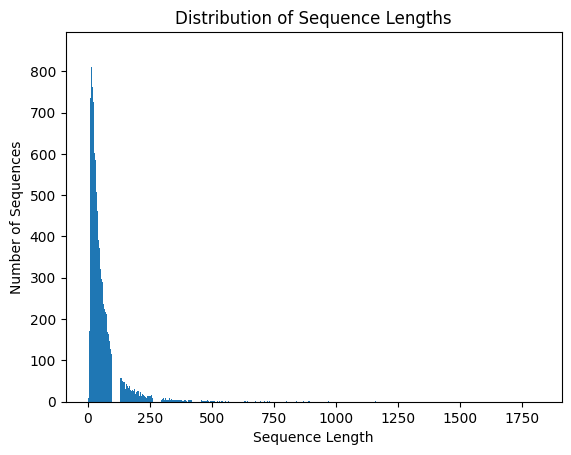

In [ ]:
sequence_counts = df_processed['sequence_length'].value_counts()

#Sort the sequence lengths in ascending order
sorted_lengths = sorted(sequence_counts.index)

x = sorted_lengths
yy = [sequence_counts[length] for length in sorted_lengths]

# Create the bar plot
import matplotlib.pyplot as plt
plt.bar(x, yy)

# Set labels and title
plt.xlabel('Sequence Length')
plt.ylabel('Number of Sequences')
plt.title('Distribution of Sequence Lengths')

# Show the plot
plt.show()

In [ ]:
# maximum/fixed length to be used in the padding part
max_len = 100

# tokenizer (or vectorizer) which transforms the sequences of tokenized and lemmatized words into sequences of integers
tokenizer = Tokenizer(num_words = len(corpus))
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(corpus)


In [ ]:
padded_sequences = pad_sequences(sequences, maxlen = max_len, padding='post', truncating='post')
padded_sequences[:2]

array([[  772,   209,     6,   650,   465,   142,     6,   153,   154,
          704,  1681,   139,   107,   163,  1719,   143,     8,     2,
           69,    51,   308,   737,    65,     4,    90,  1021,   230,
         1206,   114,    19,  1088,  1021,    49,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [  169,   122,     3,    21,   257,     6,   622,     3,   145,
          794,  4248,  2051, 24358,  1133,   695,    42,   885,  2762,
          129,  5743,   695,   885, 24359,    10,  1199,   88

In [ ]:
print("N° of unique words:", len(tokenizer.word_index))

N° of unique words: 70206


Word embedding using GloVe

In [ ]:
embeddict = {}
with open('/content/glove.6B.100d.txt', 'r') as f:
    for line in f:
        val = line.split()
        word = val[0]
        emb = np.asarray(val[1:], 'float32')
        embeddict[word] = emb
f.close()
embeddict['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [ ]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, index in tokenizer.word_index.items():
    if index < (len(tokenizer.word_index) + 1):
        word_emb = embeddict.get(word)
        if word_emb is not None and word_emb.shape[0] == 100:
          embedding_matrix[index] = word_emb


embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.15131   ,  0.20984   ,  0.44374999, ..., -0.22912   ,
         1.0266    , -0.43176001],
       [ 0.031232  , -0.15669   ,  0.31434   , ...,  0.39523   ,
         0.61461002, -0.24496999],
       ...,
       [ 0.44689   , -0.35743001, -0.308     , ...,  0.18231   ,
        -0.30548   ,  0.08873   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.37222999, -0.098291  , -0.31595999, ..., -0.073549  ,
        -0.64555001,  0.018188  ]])

In [ ]:
print(padded_sequences[:2])
print(embedding_matrix.shape)

[[  772   209     6   650   465   142     6   153   154   704  1681   139
    107   163  1719   143     8     2    69    51   308   737    65     4
     90  1021   230  1206   114    19  1088  1021    49     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [  169   122     3    21   257     6   622     3   145   794  4248  2051
  24358  1133   695    42   885  2762   129  5743   695   885 24359    10
   1199   885   682   162   140  2126   257   257  1400   117 24360   734
    988   335   540   156   241   746   174 17210   506    22 14058    59
    647   168   423   124 14059   207   157    55   258   112  2999   315
  17211   1

# Output

Since we're doing a multi-class classification task we'll use an output layer with 5 units, each representing one of the 5 classes.

 The output layer we'll use the softmax activation function. Ichose such function since I want to calculate the probability of an input to belong to a certain class and this is exactly what softmax does, it takes in a vector of raw outputs of the neural network and returns a vector of probability score.

In [ ]:
y

0        4
1        4
2        4
3        4
4        4
        ..
42651    5
42652    5
42653    5
42654    4
42655    4
Name: Rating, Length: 42656, dtype: int64

In [ ]:
#we perform one-hot encoding
y_encoded = pd.get_dummies(y)

In [ ]:
print("X shape:", padded_sequences.shape)
print("y shape:", y_encoded.shape)


X shape: (42656, 100)
y shape: (42656, 5)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42, shuffle=True)

In [ ]:
print(embedding_matrix.shape)

(70207, 100)


# Model Definition

We'll use an embedding layer that maps each word in the input text to a dense vector representation of sixe 100. Then we add two Conv1D layers, here they'll apply a set of filters to extract important patterns of the texts we've processed before.
After that we add another lavery, an RNN, more specifically a GRU, which is a variant of the LSTM. The main
difference with the LSTM is that a single gating unit simultaneously controls the
forgetting factor and the decision to update the state unit.
At the end we put a dense layer in which we apply the Softmax activation function, very important to add non-linearity to our model.


In [ ]:
model = Sequential()
# embedding layer, using the embedding matrix created above
model.add(Embedding(len(embedding_matrix), 100, weights= [embedding_matrix],
    input_length=max_len,
    trainable = False)) # this means that the word vectors are already trained in the embedding matrix
# dropout layer with dropout rate 0.2
model.add(Dropout(0.2))
# we add two convolution blocks, each made of a conv1d layer and a maxpooling layer
model.add(Conv1D(32, 5, activation='relu', padding='same'))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(64, 3, activation='relu', padding='same'))
model.add(MaxPool1D(pool_size=2))
# GRU layer
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
# Batch Normalization + Output Layer
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          7020700   
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           16032     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 64)           0         
 1D)                                                    

# Activation and Loss function


As specified in the model above we used activation functions to introduce non-linearity into the output of a neuron. We used 'ReLu' for the Conv1D layers and the 'Softmax' activation function for the output.
I decided to use the 'ReLu' since it is computationally efficient and so learn faster than other functions. The choice of 'Softmax' instead was already explained in the output part, briefly, I have a multiclass classification and I want to predict the probabilities of such classes to be detected.

To end up we also defined a loss function, which tells us how good the model is to predict the truth labels. In our case the choice is 'Categorical Crossentropy' since my true labels are one-hot encoded.


In [ ]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
934/934 [==============================] - 57s 57ms/step - loss: 1.1770 - accuracy: 0.5337 - val_loss: 1.0568 - val_accuracy: 0.5465
Epoch 2/10
934/934 [==============================] - 51s 55ms/step - loss: 1.0167 - accuracy: 0.5679 - val_loss: 0.9850 - val_accuracy: 0.5812
Epoch 3/10
934/934 [==============================] - 51s 55ms/step - loss: 0.9678 - accuracy: 0.5828 - val_loss: 0.9456 - val_accuracy: 0.5997
Epoch 4/10
934/934 [==============================] - 52s 55ms/step - loss: 0.9381 - accuracy: 0.5969 - val_loss: 0.9867 - val_accuracy: 0.5802
Epoch 5/10
934/934 [==============================] - 51s 55ms/step - loss: 0.9205 - accuracy: 0.6017 - val_loss: 0.9315 - val_accuracy: 0.6000
Epoch 6/10
934/934 [==============================] - 53s 56ms/step - loss: 0.9039 - accuracy: 0.6071 - val_loss: 0.9220 - val_accuracy: 0.6061
Epoch 7/10
934/934 [==============================] - 53s 56ms/step - loss: 0.8911 - accuracy: 0.6141 - val_loss: 0.9546 - val_accuracy:

In [ ]:
y_val_pred = model.predict(X_val)
print(y_val_pred.shape)

400/400 [==============================] - 4s 9ms/step
(12797, 5)


# Regularizers and optimizers

We evaluate the performance of our classification model using a confusion matrix to see if there an internal covariance problem. By plotting it we see that there is not such problem so I didn't use Batch Normalization anymore, I did an undersampling instead since classes are highly unbalanced.
Another thing that I did to enhance the performance is to use an optimizer, which is the Adam optimizer. This is usually used to update the weights and biases of neural networks during the training process.

400/400 [==============================] - 4s 11ms/step


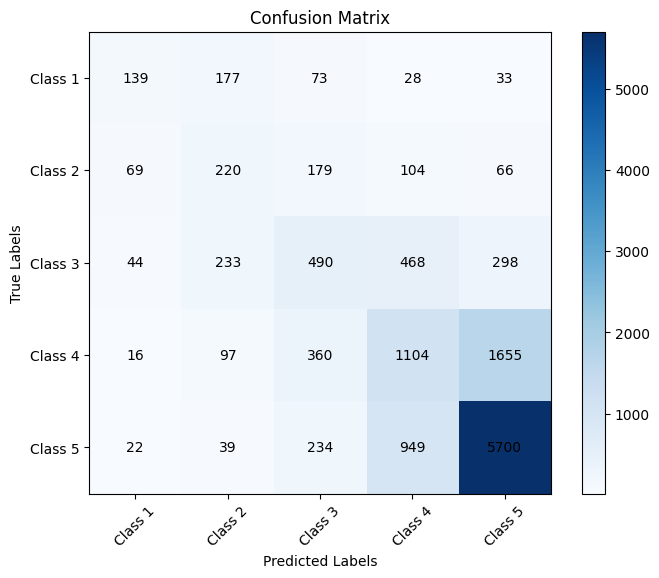

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_val_pred = model.predict(X_val)
# Convert one-hot encoded predictions to class labels
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Convert DataFrame to numpy array
y_val_np = y_val.values

# Convert one-hot encoded 'y_val' to class labels
y_val_classes = np.argmax(y_val_np, axis=1)

cm = confusion_matrix(y_val_classes, y_val_pred_classes)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_labels):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            plt.text(j, i, str(cm[i, j]), horizontalalignment='center', verticalalignment='center', color='black')
    plt.show()

class_labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']

# Plotting the confusion matrix
plot_confusion_matrix(cm, class_labels)


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# we convert the one-hot encoded target vector to integer labels
y_labels = y_encoded.idxmax(axis=1)

# we create an instance of RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# we resample the training data to balance the classes
X_resampled, y_resampled = rus.fit_resample(padded_sequences, y_labels)

# convert y back to a DataFrame
y_resampled = pd.DataFrame(y_resampled, columns=['Target'])

In [ ]:
#we do one hot encoding again
y_resampled_oneh = pd.get_dummies(y_resampled['Target'])
print(y_resampled_oneh.shape)

(7495, 5)


In [ ]:
print(X_resampled.shape)

(7495, 100)


In [ ]:
X_train_resampled, X_val_resampled, y_train_resampled, y_val_resampled = train_test_split(X_resampled, y_resampled_oneh, test_size=0.3, stratify=y_resampled_oneh, random_state=42, shuffle=True)

In [ ]:
y_train_resampled

,1,2,3,4,5
6727,0,0,0,0,1
1959,0,1,0,0,0
2963,0,1,0,0,0
5344,0,0,0,1,0
6128,0,0,0,0,1
...,...,...,...,...,...
4057,0,0,1,0,0
2459,0,1,0,0,0
6256,0,0,0,0,1
5745,0,0,0,1,0


In [ ]:
model.fit(X_train_resampled, y_train_resampled, epochs=10, validation_data=(X_val_resampled, y_val_resampled))

Epoch 1/10
164/164 [==============================] - 9s 53ms/step - loss: 1.2778 - accuracy: 0.4539 - val_loss: 1.1715 - val_accuracy: 0.5038
Epoch 2/10
164/164 [==============================] - 9s 57ms/step - loss: 1.1156 - accuracy: 0.5059 - val_loss: 1.1593 - val_accuracy: 0.4949
Epoch 3/10
164/164 [==============================] - 9s 58ms/step - loss: 1.0622 - accuracy: 0.5360 - val_loss: 1.2399 - val_accuracy: 0.4735
Epoch 4/10
164/164 [==============================] - 10s 58ms/step - loss: 1.0263 - accuracy: 0.5410 - val_loss: 1.1076 - val_accuracy: 0.5225
Epoch 5/10
164/164 [==============================] - 10s 59ms/step - loss: 0.9958 - accuracy: 0.5625 - val_loss: 1.1760 - val_accuracy: 0.5087
Epoch 6/10
164/164 [==============================] - 9s 53ms/step - loss: 0.9698 - accuracy: 0.5766 - val_loss: 1.2345 - val_accuracy: 0.4851
Epoch 7/10
164/164 [==============================] - 9s 57ms/step - loss: 0.9479 - accuracy: 0.5856 - val_loss: 1.1401 - val_accuracy: 0.51

In [ ]:
np.unique(y_val_pred_classes)

array([0, 1, 2, 3, 4])

In [ ]:
np.unique(y_val_classes)

array([0, 1, 2, 3, 4])

71/71 [==============================] - 1s 9ms/step


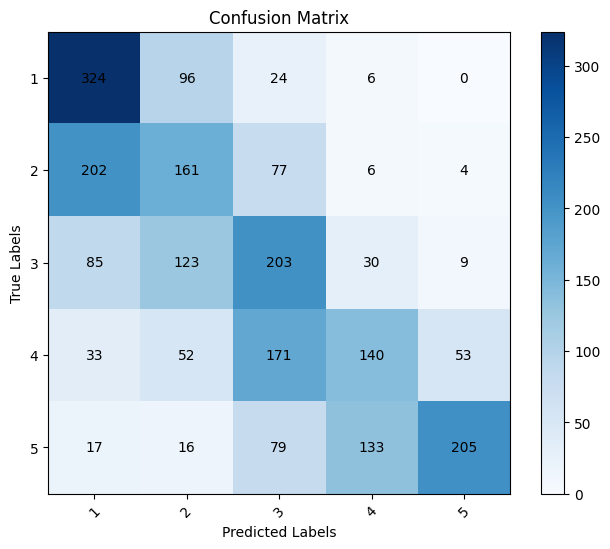

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have obtained predictions on the validation data
y_val_pred = model.predict(X_val_resampled)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Convert one-hot encoded predictions to class labels

# Convert 'y_val_resampled' from DataFrame to numpy array
y_val_classes = (y_val_resampled.idxmax(axis=1).values) - 1

cm = confusion_matrix(y_val_classes, y_val_pred_classes)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_labels):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            plt.text(j, i, str(cm[i, j]), horizontalalignment='center', verticalalignment='center', color='black')
    plt.show()

# Assuming 'class_labels' contains the names of the class labels
class_labels = y_val_resampled.columns  # Replace with your actual class labels from y_resampled_oneh

# Plotting the confusion matrix
plot_confusion_matrix(cm, class_labels)


# Model Selection

In order to make accurate predictions on unseen data we perform model selection on a defined set of hyperparameters; in our case we used the dropout and the learning rate.
The first is used to prevent overfitting, during training it randomly sets a fraction of the input units to zero dropping them out temporarily.
The last is a value that controls the model's weights and biases updatings, it's used to control convergence/divergence.

In [ ]:
! pip install scikeras
from scikeras.wrappers import KerasClassifier

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from keras.models import Sequential
from keras.layers import Embedding, Dropout, Conv1D, MaxPool1D, GRU, BatchNormalization, Dense
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

def create_model(dropout_rate=0.0, learning_rate=0.001): #learning_rate=0.001):
    model = Sequential()
    model.add(Embedding(len(embedding_matrix), 100, weights=[embedding_matrix], input_length=max_len, trainable=False))
    model.add(Dropout(dropout_rate))
    model.add(Conv1D(32, 5, activation='relu', padding='same'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(64, 3, activation='relu', padding='same'))
    model.add(MaxPool1D(pool_size=2))
    model.add(GRU(128, dropout=dropout_rate, recurrent_dropout=dropout_rate))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# hyperparameter tuning
dropout = [0, 0.1, 0.2, 0.3]
#weight_reg = [None, 'l2']
learning_rate = [0.001, 0.01, 0.1]

# we combine all hyperparameters into a list of dictionaries
param_combinations = dict(model__dropout_rate=dropout,
                          model__learning_rate=learning_rate)
param_combinations

{'model__dropout_rate': [0, 0.1, 0.2, 0.3],
 'model__learning_rate': [0.001, 0.01, 0.1]}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
model = KerasClassifier(build_fn=create_model,
                        learning_rate = 0.001,
                        dropout_rate=0.1,
                        epochs = 10)

In [ ]:
RS = RandomizedSearchCV(estimator=model, param_distributions=param_combinations,
                  n_jobs=-1,
                  scoring='accuracy',
                  refit=True,
                  cv=3,
                  verbose = 1,
                  return_train_score=True,
                        error_score='raise')

rs_result = RS.fit(X_resampled[:100], y_resampled_oneh[:100])
# best result
print("Best: %f using %s" % (rs_result.best_score_,
                             rs_result.best_params_))
means = rs_result.cv_results_['mean_test_score']
params = rs_result.cv_results_['params']
# printing results for all combinations
for mean, param in zip(means, params):
    print(f"{mean} \t with: {param}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
4/4 [==============================] - 3s 46ms/step - loss: 1.8507 - accuracy: 0.0500
Epoch 2/10
4/4 [==============================] - 0s 49ms/step - loss: 1.6631 - accuracy: 0.0700
Epoch 3/10
4/4 [==============================] - 0s 47ms/step - loss: 1.5841 - accuracy: 0.7900
Epoch 4/10
4/4 [==============================] - 0s 42ms/step - loss: 1.5392 - accuracy: 0.2200
Epoch 5/10
4/4 [==============================] - 0s 46ms/step - loss: 1.4440 - accuracy: 0.8100
Epoch 6/10
4/4 [==============================] - 0s 45ms/step - loss: 1.3766 - accuracy: 0.8100
Epoch 7/10
4/4 [==============================] - 0s 46ms/step - loss: 1.3236 - accuracy: 0.8300
Epoch 8/10
4/4 [==============================] - 0s 43ms/step - loss: 1.2555 - accuracy: 0.8400
Epoch 9/10
4/4 [==============================] - 0s 44ms/step - loss: 1.1905 - accuracy: 0.9100
Epoch 10/10
4/4 [==============================] - 0s 50ms/step - loss: 1.1335 - accuracy: 0.9100
Best: 1.000000 using {'model_

In [ ]:
model = create_model(
    dropout_rate=0.1,
    learning_rate=0.1)

history = model.fit(X_train_resampled, y_train_resampled, epochs=10)

Epoch 1/10
164/164 [==============================] - 19s 98ms/step - loss: 1.6382 - accuracy: 0.2394
Epoch 2/10
164/164 [==============================] - 15s 91ms/step - loss: 1.5055 - accuracy: 0.3185
Epoch 3/10
164/164 [==============================] - 9s 54ms/step - loss: 1.3554 - accuracy: 0.3791
Epoch 4/10
164/164 [==============================] - 9s 54ms/step - loss: 1.2826 - accuracy: 0.4186
Epoch 5/10
164/164 [==============================] - 8s 49ms/step - loss: 1.2118 - accuracy: 0.4584
Epoch 6/10
164/164 [==============================] - 9s 54ms/step - loss: 1.1576 - accuracy: 0.4863
Epoch 7/10
164/164 [==============================] - 9s 54ms/step - loss: 1.1017 - accuracy: 0.5063
Epoch 8/10
164/164 [==============================] - 9s 54ms/step - loss: 1.0310 - accuracy: 0.5381
Epoch 9/10
164/164 [==============================] - 12s 70ms/step - loss: 0.9905 - accuracy: 0.5614
Epoch 10/10
164/164 [==============================] - 8s 51ms/step - loss: 0.9360 - acc

# Evaluating generalization capabilities

We use the loss score to evaluate how much the model's predictions deviate from the true values and the accuracy as a measure of the model's correctness in predicting the classes.

In [ ]:
loss, accuracy = model.evaluate(X_val, y_val)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

400/400 [==============================] - 4s 10ms/step - loss: 1.8316 - accuracy: 0.3592
Loss: 1.8315503597259521
Accuracy: 0.3592248260974884
